### Set THRESHOLD_RANK, NEIGHBORS_ONLY, PPR_THRESHOLD_ONLY in communities.py accordingly.

In [1]:
import json
import random
import os
import pickle
import time
import shutil
import sys
import uuid
from collections import defaultdict
from datetime import timedelta
from glob import glob

import leidenalg as la
import igraph as ig
import numpy as np
import pandas as pd
import seaborn as sns
import psutil
from pyspark.sql import functions as sf
from pyspark import SparkConf
from pyspark.sql import SparkSession

import settings as s
from common import get_processes

%load_ext autoreload
%autoreload 2

In [2]:
sns.set_theme(style="white", context="talk")

In [3]:
if (
    sys.version_info.major,
    sys.version_info.minor,
    sys.version_info.micro,
) != (3, 11, 8):
    raise EnvironmentError(
        "Only runs efficiently on Python 3.11.8 (Tested on: Conda 24.1.2 | Apple M3 Pro)"
    )

In [4]:
config = [
    ("spark.driver.memory", "16g"),
    ("spark.worker.memory", "16g"),
    ("spark.driver.maxResultSize", "16g"),
]
spark = (
    SparkSession.builder.appName("testing")
    .config(conf=SparkConf().setAll(config))
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/25 18:28:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
start_script = time.time()

In [6]:
MAX_DEGREE_PER_ACCOUNT = 100
MAX_TRANSACTIONS_PER_ACCOUNT = 1_000

data = spark.read.parquet(s.STAGED_DATA_LOCATION)

#### [START] Seed selection ####
data = data.where(sf.col("source") != sf.col("target"))
data = data.where(sf.col("format").isin(["ACH", "Wire", "Bitcoin"]))

large_sources = (
    data.groupby("source")
    .count()
    .where(sf.col("count") > MAX_TRANSACTIONS_PER_ACCOUNT)
    .select("source")
    .toPandas()["source"]
    .tolist()
)
large_targets = (
    data.groupby("target")
    .count()
    .where(sf.col("count") > MAX_TRANSACTIONS_PER_ACCOUNT)
    .select("target")
    .toPandas()["target"]
    .tolist()
)

large_sources = set(large_sources).union(
    data.groupby("source")
    .agg(sf.countDistinct("target").alias("count"))
    .where(sf.col("count") > MAX_DEGREE_PER_ACCOUNT)
    .select("source")
    .toPandas()["source"]
    .tolist()
)
large_targets = set(large_targets).union(
    data.groupby("target")
    .agg(sf.countDistinct("source").alias("count"))
    .where(sf.col("count") > MAX_DEGREE_PER_ACCOUNT)
    .select("target")
    .toPandas()["target"]
    .tolist()
)

data = data.where(~sf.col("source").isin(large_sources))
data = data.where(~sf.col("target").isin(large_targets))
#### [END] Seed selection ####

In [7]:
def aggregate_edges(data_input):
    data_aggregated = (
        data_input.groupby(["source", "target"])
        .agg(
            sf.sum("source_amount").alias("source_amount"),
            sf.sum("target_amount").alias("target_amount"),
        )
        .toPandas()
    )

    source_totals = (
        data_aggregated.groupby("source")
        .agg({"source_amount": "sum"})["source_amount"]
        .to_dict()
    )
    target_totals = (
        data_aggregated.groupby("target")
        .agg({"target_amount": "sum"})["target_amount"]
        .to_dict()
    )

    data_aggregated.loc[:, "total_sent_by_source"] = data_aggregated.loc[
        :, "source"
    ].apply(lambda x: source_totals[x])
    data_aggregated.loc[:, "total_received_by_target"] = data_aggregated.loc[
        :, "target"
    ].apply(lambda x: target_totals[x])
    data_aggregated.loc[:, "weight"] = data_aggregated.apply(
        lambda x: (
            (x["source_amount"] / x["total_sent_by_source"])
            + (x["target_amount"] / x["total_received_by_target"])
        ),
        axis=1,
    )
    data_aggregated.loc[:, "source"] = data_aggregated["source"].str.slice(0, 8)
    data_aggregated.loc[:, "target"] = data_aggregated["target"].str.slice(0, 8)
    filter_self = data_aggregated["source"] != data_aggregated["target"]
    data_aggregated = data_aggregated.loc[filter_self, :].reset_index(drop=True)
    return data_aggregated.loc[:, ["source", "target", "weight"]]

In [8]:
%%time

edges = aggregate_edges(data)
graph = ig.Graph.DataFrame(edges, use_vids=False, directed=True)
nodes = [x["name"] for x in graph.vs()]
random.shuffle(nodes)

CPU times: user 30.8 s, sys: 580 ms, total: 31.4 s
Wall time: 41.7 s


In [9]:
nodes_mapping = {x.index: x["name"] for x in graph.vs()}

In [10]:
%%time

NUMBER_OF_PROCESSES = 10

shutil.rmtree("staging", ignore_errors=True)
os.mkdir("staging")
chunks = np.array_split(nodes, NUMBER_OF_PROCESSES)

filename = "graph.pickle"
with open(filename, "wb") as f:
    pickle.dump(graph, f, protocol=pickle.HIGHEST_PROTOCOL)

filename = "nodes.pickle"
with open(filename, "wb") as f:
    pickle.dump(chunks, f, protocol=pickle.HIGHEST_PROTOCOL)

process_ids = set()
process_name = "communities.py"
for chunk_number in range(NUMBER_OF_PROCESSES):
    process_id = str(uuid.uuid4())
    process_ids = process_ids.union({process_id})
    os.system(f"{sys.executable} {process_name} {chunk_number} {process_id} &")

while get_processes(process_ids):
    time.sleep(5)

Done -> 6
Done -> 8
Done -> 4
Done -> 9
Done -> 3
Done -> 7
Done -> 2
Done -> 5
Done -> 1
Done -> 0
CPU times: user 2.01 s, sys: 2.64 s, total: 4.66 s
Wall time: 6min 31s


In [11]:
%%time

for proc in get_processes(process_ids):
    try:
        proc.kill()
    except psutil.NoSuchProcess:
        pass

communities = []
for filename in glob("./staging/*.pickle"):
    with open(filename, "rb") as f:
        communities += pickle.load(f)

original_size = len(communities)

filename = "communities.pickle"
with open(filename, "wb") as f:
    pickle.dump(communities, f)

communities_unique_rev = {}
for comm_id, comm in communities:
    communities_unique_rev[tuple(sorted(comm))] = comm_id

communities_unique = {
    f"{v}-{i}": k for i, (k, v) in enumerate(communities_unique_rev.items())
}
communities = list({x for x in communities_unique.values()})
new_size = len(communities)

print(original_size, new_size, round(new_size / original_size, 2))
print()

28567913 10590657 0.37

CPU times: user 2min 16s, sys: 45.7 s, total: 3min 1s
Wall time: 3min 30s


In [12]:
sizes = [len(x) for x in communities]
round(np.mean(sizes)), round(np.max(sizes)), sum(sizes)

(14, 48, 152485638)

In [13]:
np.percentile(sizes, 25), np.percentile(sizes, 50), np.percentile(sizes, 75)

(np.float64(9.0), np.float64(13.0), np.float64(19.0))

<Axes: xlabel='Size', ylabel='Count'>

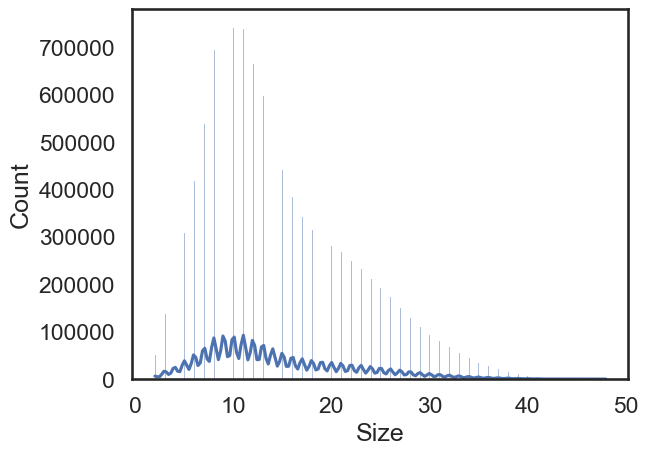

In [14]:
## sns.set_theme(rc={"figure.figsize":(12.7, 7.27)})
sns.histplot(data=pd.DataFrame(sizes, columns=["Size"]), x="Size", kde=True)

<Axes: >

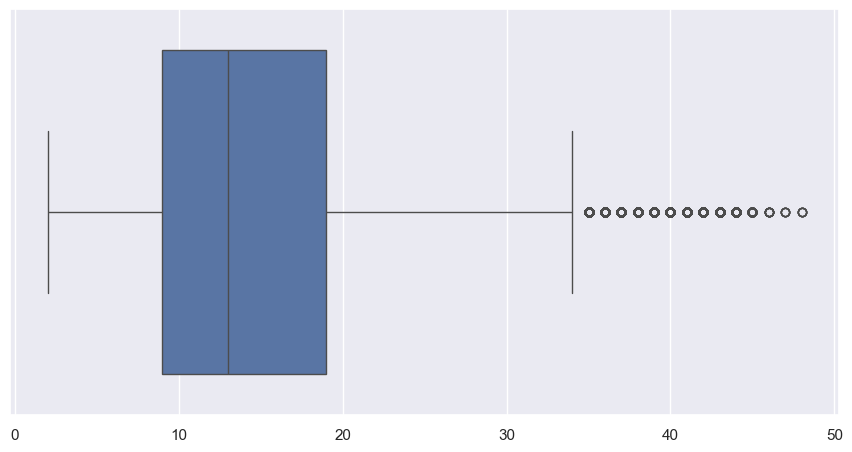

In [15]:
sns.set_theme(rc={"figure.figsize": (10.7, 5.27)})
sns.boxplot(x=sizes)

In [16]:
flow_stats = pd.read_parquet("flow_stats.parquet")
flow_stats.loc[:, "turnover_ranks"] = flow_stats.loc[:, "turnover_ranks"].apply(
    lambda x: json.loads(x)
)

## Analyzing the quality / completeness of the detected communities

In [17]:
%%time

search_hash = defaultdict(list)
for index, community in enumerate(communities):
    for node in community:
        search_hash[node].append(index)

CPU times: user 34.6 s, sys: 588 ms, total: 35.2 s
Wall time: 35.3 s


In [18]:
%%time

percentages = []
start = time.time()
for index, stats in flow_stats.iterrows():
    turnover_ranks = stats["turnover_ranks"]
    flow_nodes = list(turnover_ranks.keys())
    matches = []
    perc = 0
    for node in flow_nodes:
        for i in search_hash[node]:
            in_scope = set(communities[i])
            matched_nodes = in_scope.intersection(flow_nodes)
            matched_perc = sum([turnover_ranks[x] for x in matched_nodes])
            matches.append((node, matched_perc, -len(in_scope)))
    try:
        matched_node_comm, matched_perc, matched_comm_size = sorted(
            matches, reverse=True, key=lambda x: (x[1], x[2])
        )[0]
    except IndexError:
        continue
    stats = stats.to_dict()
    stats["score"] = matched_perc
    stats["matched_node_comm"] = matched_node_comm
    stats["matched_comm_size"] = -matched_comm_size
    percentages.append(dict(stats))
    if not (index % 2_000):
        print(index, round(time.time() - start))
        start = time.time()

percentages = pd.DataFrame(percentages)

0 0
2000 10
4000 5
6000 7
8000 8
10000 16
12000 6
14000 9
16000 14
CPU times: user 1min 19s, sys: 197 ms, total: 1min 19s
Wall time: 1min 19s


In [19]:
float(round(percentages["matched_comm_size"].mean(), 2))

11.94

In [20]:
float(round(percentages["matched_comm_size"].max(), 2))

43.0

In [21]:
float(round(percentages["score"].mean() * 100, 2))

86.78

In [22]:
round(
    (percentages[percentages["score"] >= 0.99].shape[0] / percentages.shape[0]) * 100, 2
)

70.22

<Axes: xlabel='type'>

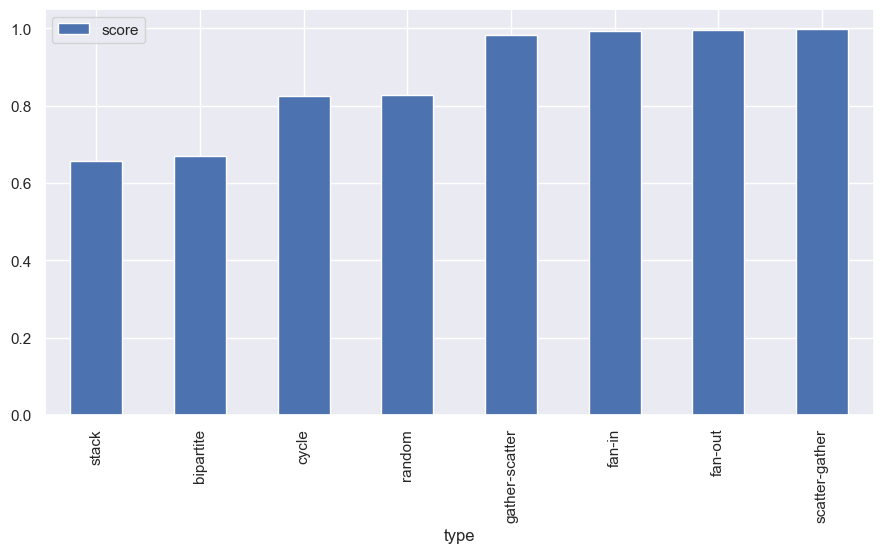

In [23]:
percentages.groupby("type").agg({"score": "mean"}).sort_values("score").plot.bar()

<Axes: xlabel='type'>

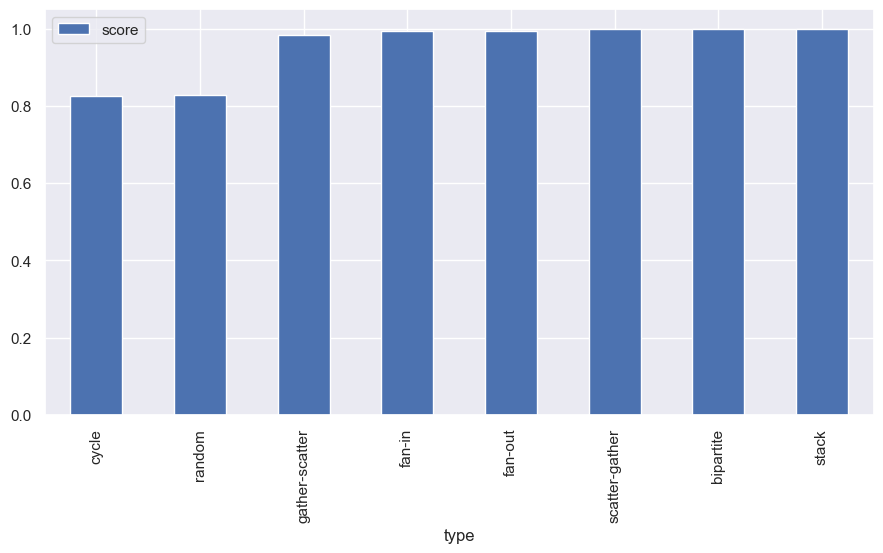

In [24]:
filter_ = percentages["number_components"] == 1
percentages_scope = percentages.loc[filter_, :].reset_index(drop=True)
percentages_scope.groupby("type").agg({"score": "mean"}).sort_values("score").plot.bar()

In [25]:
percentages_scope.groupby("type").agg({"score": "mean"}).sort_values("score")

,score
type,
cycle,0.825541
random,0.827330
gather-scatter,0.982816
fan-in,0.994686
fan-out,0.995030
scatter-gather,0.999677
bipartite,1.000000
stack,1.000000


In [26]:
percentages_scope[percentages_scope["score"] < 1].shape[0]

4365

In [27]:
delta = round(time.time() - start_script)
print(f"Script executed in {timedelta(seconds=delta)}")

Script executed in 0:13:35
